# Assignment 2 - Predictive Process Monitoring

**Due: Wednesday, 11 December, 2024 at 17:00 CET**

In this assignment, you will learn to train a regression model to predict the remaining time of a process. Additionally, you will demonstrate your ability to evaluate the model's performance and discuss the results in a report. The learning objectives of this assignment are to:

- Apply data cleaning, data transformation, and feature encoding techniques to preprocess event data.
- Use regression models to predict the remaining time of ongoing cases.
- Calculate model performance metrics (e.g., MAE, MSE, RMSE, \(R^2\), etc.).
- Refine the experimental design to compare the performance of different preprocessing and encoding methods.
- Reflect on the differences between various methods and their effect on the model performance.


## Tasks Overview

This assignment includes six tasks:

1. **Data Exploration:** Perform data exploration to understand the dataset.
2. **Data Preprocessing and Trace Encoding:** Apply data preprocessing and trace encoding (covered during Lectures 5 and 7).
3. **Regression Model Training:** Select a regression algorithm of interest and train a regression model (a regressor) to forecast the remaining time of each case after each event (see Lecture 6)
4. **Prefix-Length Buckets:** Create buckets of different prefix lengths and train a separate regressor for each bucket (covered during Lectures 5 and 7).
5. **Alternative Methods:** Revisit your design decisions and investigate two additional methods that may improve model performance.
6. **Evaluation:** Evaluate the results.

### Notes

- You may reuse your code from Tasks 2 and 3 in Tasks 4 and 5.
- For Task 6 and your report, ensure that you save all the calculated metrics (MAE, MSE, RMSE, and \(R^2\)) in previous tasks. Save these metrics in a list or dictionary to facilitate easy evaluation and comparison of results.




## Task 1: Exploring the data set



### Data set: Sepsis

Import the file *Complete Sepsis.csv* to load the Sepsis data set. This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents a patient's pathway through the treatment process. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. The original data set contains about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists.

Additional information about the data can be found :
- https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639
- http://ceur-ws.org/Vol-1859/bpmds-08-paper.pdf




In [2]:
# Import packages
import pandas as pd

# Import data
# TODO: Change the file path to your file path
data_Sepsis = pd.read_csv("./Complete Sepsis.csv", sep=",")

# create an overview of the data
print(data_Sepsis.describe())
print(data_Sepsis.columns)
# print(data_Sepsis.head())

# Print the activities that occurred in the process
print(data_Sepsis['Activity'].unique())

# Print the cases (patients) that are following the process
print(data_Sepsis['Case ID'].unique())

# for variable in data_Sepsis.columns:
#     print(variable)
#     print(data_Sepsis[variable].unique())

       Variant index         Age   Leucocytes          CRP   LacticAcid
count   13333.000000  777.000000  3075.000000  2884.000000  1281.000000
mean      360.079127   71.833977    12.985463   114.368585     1.902420
std       214.255001   15.573718    15.512797    86.366989     1.442281
min         1.000000   20.000000     0.200000     5.000000     0.200000
25%       176.000000   60.000000     7.700000    44.000000     1.100000
50%       360.000000   75.000000    10.900000    96.000000     1.500000
75%       547.000000   85.000000    15.000000   163.000000     2.200000
max       728.000000   90.000000   381.300000   573.000000    14.900000
Index(['Case ID', 'Activity', 'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'org:group', 'InfectionSuspected',
       'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie',
       'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor'

### Create the Labels by Calculating the Remaining Time

To forecast the remaining time for each patient in the hospital, we group the events by patient, use the completion time of each patient (i.e., the timestamp of the last event for each patient), and calculate the time difference between the current event and the completion time. This is done for each event. As a result, we now have our labels, which indicate how long a patient will remain in the treatment process for each event.

To help you get started, we created the target variable *remaining_time(days)* for you.

In [3]:
df = data_Sepsis.copy()

# Convert the timestamp column to datetime
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])

# Find the completion time for each case
completion_times = df.groupby('Case ID')['Complete Timestamp'].max().rename('completion_time')

# Merge completion time back into the original DataFrame
df = df.merge(completion_times, on='Case ID')

# Calculate the remaining time for each event
df['remaining_time'] = df['completion_time'] - df['Complete Timestamp']

# Calculate the remaining time for each event in days
df['remaining_time(days)'] = df['remaining_time'].dt.total_seconds()/60/60/24

# Retain rows where the remaining time is larger than 0 days.
df = df[df['remaining_time(days)'] > 0]

# Drop the completion_time column to avoid information leakage
df = df.drop(columns=['completion_time'])

# Drop the remaining_time column to avoid information leakage
df = df.drop(columns=['remaining_time'])

# Display the result
label_column = 'remaining_time(days)'

# Fill in the column names of case id, activity, and time stamps
column_Sepsis_CaseID = 'Case ID'
column_Sepsis_Activity = 'Activity'
column_Sepsis_Timestamps = 'Complete Timestamp'

print(df)

      Case ID         Activity  Complete Timestamp      Variant  \
0           A  ER Registration 2014-10-22 11:15:41   Variant 35   
1           A       Leucocytes 2014-10-22 11:27:00   Variant 35   
2           A              CRP 2014-10-22 11:27:00   Variant 35   
3           A       LacticAcid 2014-10-22 11:27:00   Variant 35   
4           A        ER Triage 2014-10-22 11:33:37   Variant 35   
...       ...              ...                 ...          ...   
13303     KNA              CRP 2014-12-13 07:00:00  Variant 728   
13304     KNA       Leucocytes 2014-12-14 07:00:00  Variant 728   
13305     KNA       LacticAcid 2014-12-14 07:00:00  Variant 728   
13306     KNA       Leucocytes 2014-12-16 07:00:00  Variant 728   
13307     KNA              CRP 2014-12-16 07:00:00  Variant 728   

       Variant index lifecycle:transition org:group InfectionSuspected  \
0                 35             complete         A               True   
1                 35             complete      


### 1.1 Exploratory data analysis

For the data set, create 2-3 figures/tables that help you understand the data

Note that some of these variables are categorical variables and some are numberical. Additionally, some of the variables have missing values. Think/discuss how would you preprocess these variables.


Make sure to at least check each variable's data type and understand their distribution.

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*

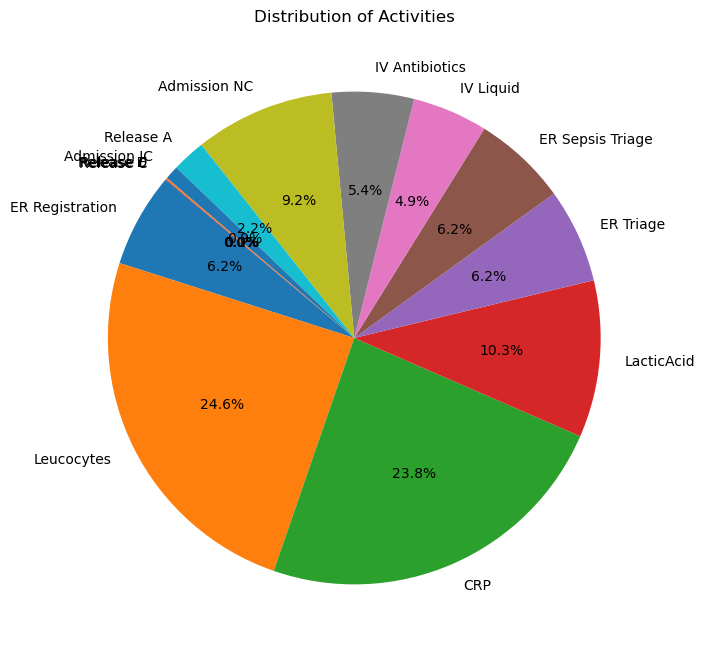

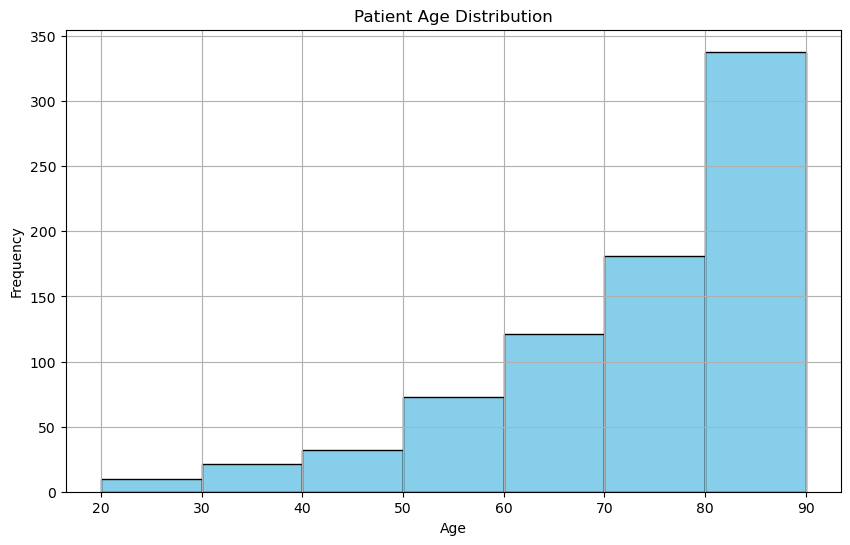

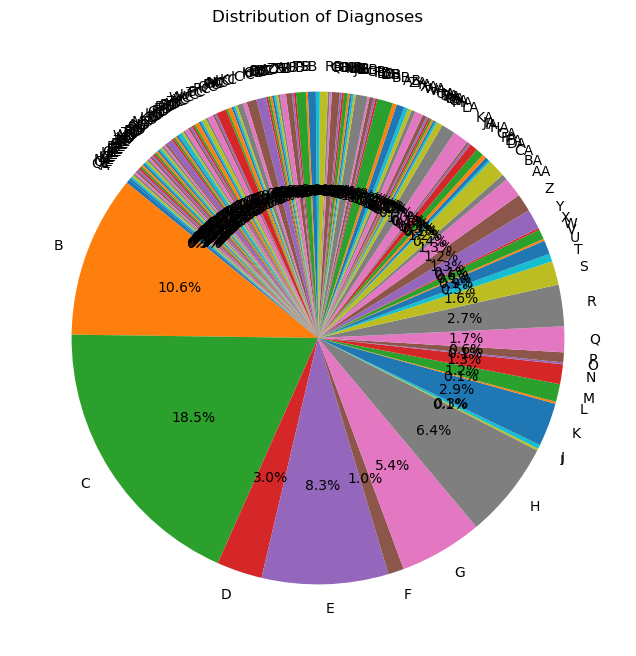

In [4]:
# import packages
import matplotlib.pyplot as plt
from collections import Counter

# TODO: plot figure(s)

# Piechart showing distribution of different activities
# Count occurrences of each activity
activity_counts = Counter(df['Activity'])

# Prepare data for pie chart
activities = list(activity_counts.keys())
counts = list(activity_counts.values())

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=activities, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Activities')
plt.show()

# Histogram showing the age ranges of the patients
# Get unique patients
df_unique_patients = df.drop_duplicates(subset=['Case ID'])

# Create histogram with an age range 20-90 with 10 year wide bins
plt.figure(figsize=(10, 6))
plt.hist(df_unique_patients['Age'], bins=range(20, 100, 10), color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Patient Age Distribution')
plt.grid(True)
plt.show()

# Drop rows with NaN values in the 'Diagnose' column
no_nan_diagnose = df.dropna(subset=['Diagnose'])

# Count occurrences of each diagnosis
diagnose_counts = Counter(no_nan_diagnose['Diagnose'])

# Prepare data for pie chart
diagnoses = list(diagnose_counts.keys())
d_counts = list(diagnose_counts.values())

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(d_counts, labels=diagnoses, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Diagnoses')
plt.show()

### (Optional) 1.2 Process Discovery and Visualization

This is an optional task to show you how process discovery and visualizaion can be deployed using the pm4py library.

(*The following code requires the graphviz library to be installed. If you have issues with installing the graphviz, you may try to follow the instructions on Install GraphViz on the [pm4py](https://pm4py.fit.fraunhofer.de/install-page) install page*)

The following code:
- fill in the columns for case id, activity, and timestamps
- convert the data set into an event log
- discover a Directly-follows graph (DFG) and a process model for each event log.
- you may use the discovered process model in your report



In [5]:
# If you have brew installed, install graphviz brew install graphviz
# Then install pm4py library and graphviz library using pip install
# !pip install -U pm4py
# !conda install graphviz
# !conda install python-graphviz
import pm4py

data_Sepsis[column_Sepsis_CaseID] = data_Sepsis[column_Sepsis_CaseID].astype(str)

data_Sepsis_copy = data_Sepsis.copy()
data_Sepsis_copy['Complete Timestamp'] = pd.to_datetime(data_Sepsis_copy['Complete Timestamp'])

# Convert the data to an event log
log_Sepsis = pm4py.format_dataframe(data_Sepsis_copy, case_id=column_Sepsis_CaseID, activity_key=column_Sepsis_Activity, timestamp_key=column_Sepsis_Timestamps)

# Set the log to be the one that you are interested
log = log_Sepsis

# Create a Directly-Follows Graph (DFG) and plot this graph
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
# pm4py.view_dfg(dfg, start_activities, end_activities) (tijdelijk comment zodat het bestand te openen is in github)

# Discover a Process Model using Inductive Miner and plot this BPMN model
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
# pm4py.view_bpmn(bpmn_model) (tijdelijk comment zodat het bestand te openen is in github)


ModuleNotFoundError: No module named 'pm4py'

## Task 2: Preprocessing and Trace Encoding

### 2.1 Data preprocessing

In the previous data exploration task, you gathered some initial insights about the dataset. Based on your observations during data exploration, decide which preprocessing steps are necessary (e.g., handling missing values, encoding categorical variables, scaling numerical features, etc.) and implement them accordingly.

In [6]:
from sklearn.preprocessing import MinMaxScaler
# TODO: decide on how you handle missing values (ranging from dropping columns and dropping rows to filling in the empty cells)

# Only keeps the rows with the following entries under column "Activity", since other entries under "Activity" don't hold any useful information.
df_drop = df[df['Activity'].isin(['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid'])].copy()

# Fills missing values with either the mean or median depending on the type
df_drop['Age'] = df_drop['Age'].fillna(df_drop['Age'].median())
df_drop['Leucocytes'] = df_drop['Leucocytes'].fillna(df_drop['Leucocytes'].mean())
df_drop['CRP'] = df_drop['CRP'].fillna(df_drop['CRP'].mean())
df_drop['LacticAcid'] = df_drop['LacticAcid'].fillna(df_drop['LacticAcid'].mean())

# This will still showcase missing values, but these missing values are supposed to be "missing"
# Since a patient has multiple row entries, and these values only take one row per patient, meaning the other rows will consistently stay empty
print(df_drop.isnull().sum())

# TODO: perform data preprocessing steps

scaler = MinMaxScaler()
df_scale = df_drop.copy()
df_scale[['Age', 'Leucocytes', 'CRP', 'LacticAcid']] = scaler.fit_transform(df_scale[['Age', 'Leucocytes', 'CRP', 'LacticAcid']])

# Prints the final DataFrame after scaling
print(df_scale)

Case ID                         0
Activity                        0
Complete Timestamp              0
Variant                         0
Variant index                   0
lifecycle:transition            0
org:group                       0
InfectionSuspected           7355
DiagnosticBlood              7355
DisfuncOrg                   7355
SIRSCritTachypnea            7355
Hypotensie                   7355
SIRSCritHeartRate            7355
Infusion                     7355
DiagnosticArtAstrup          7355
Age                             0
DiagnosticIC                 7355
DiagnosticSputum             7355
DiagnosticLiquor             7355
DiagnosticOther              7355
SIRSCriteria2OrMore          7355
DiagnosticXthorax            7355
SIRSCritTemperature          7355
DiagnosticUrinaryCulture     7355
SIRSCritLeucos               7355
Oligurie                     7355
DiagnosticLacticAcid         7355
Diagnose                     7381
Hypoxie                      7355
DiagnosticUrin

### 2.2 Trace Encoding


- Implement the aggregation encoding for the data set (for example, see [1], Table 6)

<span style="color:gray">[1] Ilya Verenich, Marlon Dumas, Marcello La Rosa, Fabrizio Maria Maggi, Irene Teinemaa:
Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring. ACM Trans. Intell. Syst. Technol. 10(4): 34:1-34:34 (2019) [Section 1, 2, 4.1, 4.3, 4.6, 5.2, 5.3, 5.4, and 6] </span>

This encoding has been discussed during lecture 7.
- for the aggregation encoding check the pandas groupby.DataFrameGroupBy and cumsum function and read the [examples and answers on the stake overflow](https://stackoverflow.com/a/49578219)

In [7]:
# TODO: Implement the function that returns the aggregation state encoding of a log
def agg_per_event_encoding(dataFrame, column_Sepsis_CaseID, column_Sepsis_Activity):
    _new_data = dataFrame.copy()

    # TODO: Apply one-hot encoding to the 'activity' column
    onehot = pd.get_dummies(_new_data[column_Sepsis_Activity], prefix=column_Sepsis_Activity)
    _new_data = pd.concat([_new_data, onehot], axis=1)

    # TODO: Group by 'case id' and compute the cumulative sum for each activity
    cumulative_freq = _new_data.groupby([column_Sepsis_CaseID])[onehot.columns].cumsum()

    # TODO: Concatenate the original DataFrame with the cumulative frequencies
    _data_with_features = pd.concat([_new_data, cumulative_freq], axis=1)

    return(_data_with_features)

# Applies aggregated state encoding to the data set
data_Sepsis_ag = agg_per_event_encoding(df, column_Sepsis_CaseID, column_Sepsis_Activity)

print(data_Sepsis_ag)

      Case ID         Activity  Complete Timestamp      Variant  \
0           A  ER Registration 2014-10-22 11:15:41   Variant 35   
1           A       Leucocytes 2014-10-22 11:27:00   Variant 35   
2           A              CRP 2014-10-22 11:27:00   Variant 35   
3           A       LacticAcid 2014-10-22 11:27:00   Variant 35   
4           A        ER Triage 2014-10-22 11:33:37   Variant 35   
...       ...              ...                 ...          ...   
13303     KNA              CRP 2014-12-13 07:00:00  Variant 728   
13304     KNA       Leucocytes 2014-12-14 07:00:00  Variant 728   
13305     KNA       LacticAcid 2014-12-14 07:00:00  Variant 728   
13306     KNA       Leucocytes 2014-12-16 07:00:00  Variant 728   
13307     KNA              CRP 2014-12-16 07:00:00  Variant 728   

       Variant index lifecycle:transition org:group InfectionSuspected  \
0                 35             complete         A               True   
1                 35             complete      

### 2.3 Create training and test data sets using temporal split


Choose the size of your test data and use that to find the appropiate date (time threshold) to split the dataset into training  and test set.

This approach is commonly used for time-series or event log data to ensure that training data comes from earlier time periods and test data from later periods. This avoids data leakage, where future data might influence the training process.

When writing your report, explain how you split the data and provide a justification for your choice as part of the experiment setup discussion.

In [8]:
# Define time threshold
time_threshold = pd.Timestamp('2014-09-30 00:00:00')

# Split the case
def train_test_time_based_split(data_frame, time_threshold, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, column_label):

    # TODO: Identify the start time of each case
    case_start_time = data_frame.groupby(column_Sepsis_CaseID)[column_Sepsis_Timestamps].min()

    # TODO: Separate case IDs into training and test sets
    train_case_ids = case_start_time[case_start_time < time_threshold].index
    test_case_ids = case_start_time[case_start_time >= time_threshold].index

    # TODO: Assign rows to training and test sets based on case IDs
    train_data = data_frame[data_frame[column_Sepsis_CaseID].isin(train_case_ids)]
    test_data = data_frame[data_frame[column_Sepsis_CaseID].isin(test_case_ids)]

    # TODO : Create the training and test sets, while dropping the irrelevant columns
    X_train = train_data.drop([column_Sepsis_CaseID, column_Sepsis_Activity, column_label, column_Sepsis_Timestamps], axis=1)
    y_train = train_data[column_label]

    X_test = test_data.drop([column_Sepsis_CaseID, column_Sepsis_Activity, column_label, column_Sepsis_Timestamps], axis=1)
    y_test = test_data[column_label]

    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_time_based_split(data_Sepsis_ag, time_threshold, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

## Task 3: Predicting Case Remaining Time


In this task, you will train a regression model (aka regressor) to predict case remaining time.
You may choose the regression tree, the random forest regression, the kNN-regressor, or the MLP for regression. Very similar to how you have trained a classification model in Assignment 1, now perform the following steps to train a regression model.

A) use the default values for the parameters to get a regressor on the training data.
- [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

(OPTIONAL) use 5-fold cross-validation to tune the parameters. And create plots to show how the selected parameters affect the performance.

B) select the best-performing regressor (e.g., the default one or the one that achieved the lowest error) and report the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the test data.

    
#### TIPS:
In case you decide to perform cross-validation, you are allowed to reuse some of your code from Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)



Default Random Forest Regressor Performance:
MAE: 49.2898, MSE: 7034.7403, RMSE: 83.8734, R^2: -4.5205
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Random Forest Regressor Performance:
MAE: 47.9278, MSE: 6537.2775, RMSE: 80.8534, R^2: -4.1301


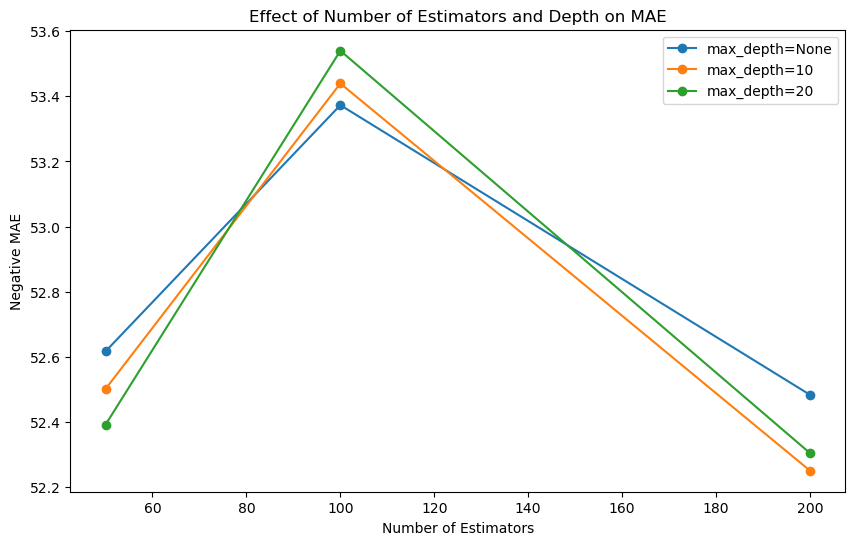

In [9]:
# TODO: import packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV

# fill NaN's bcs I got error
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# TODO: Train a regression model (e.g., Random Forest Regressor)
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_default = rf_default.predict(X_test)

# TODO: Evaluate the regressor on the test data and print the errors
mae_default = mean_absolute_error(y_test, y_pred_default)
mse_default = mean_squared_error(y_test, y_pred_default)
rmse_default = np.sqrt(mse_default)
r2_default = r2_score(y_test, y_pred_default)

print(f"Default Random Forest Regressor Performance:\nMAE: {mae_default:.4f}, MSE: {mse_default:.4f}, RMSE: {rmse_default:.4f}, R^2: {r2_default:.4f}")

# TODO: Train a regression model (e.g., Random Forest Regressor)
# Optional cross-validation with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# TODO: Evaluate the regressor on the test data and print the errors
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Random Forest Regressor Performance:\nMAE: {mae_best:.4f}, MSE: {mse_best:.4f}, RMSE: {rmse_best:.4f}, R^2: {r2_best:.4f}")

# Plotting results
results = grid_search.cv_results_
n_estimators = [50, 100, 200]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, -results['mean_test_score'][::6], marker='o', label='max_depth=None')
plt.plot(n_estimators, -results['mean_test_score'][1::6], marker='o', label='max_depth=10')
plt.plot(n_estimators, -results['mean_test_score'][2::6], marker='o', label='max_depth=20')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MAE')
plt.title('Effect of Number of Estimators and Depth on MAE')
plt.legend()
plt.show()

## Task 4. Create three buckets and repeat Tasks 2 and 3 for each bucket.

In this task, you will create three buckets, for prefix length 5, 10 and 15. For each of the bucket, repeat Task 2 and 3.  

You may use the functions you built for Tasks 2 and 3 or reuse code.

Calculate the error measures (MAE, MSE, RMSE, R^2) and discuss the results.

In [14]:
# Group by case_id and create a prefix column
df['prefix'] = df.groupby(column_Sepsis_CaseID).cumcount() + 1

# Buckets for prefix lengths 5, 10, and 15
buckets = {5: [], 10: [], 15: []}

# Populate the buckets based on prefix ranges
for index, row in df.iterrows():
    prefix = row['prefix']
    if 1 <= prefix <= 5:
        buckets[5].append(row)
    elif 6 <= prefix <= 10:
        buckets[10].append(row)
    elif 11 <= prefix <= 15:
        buckets[15].append(row)

# Convert lists of rows back to DataFrames
buckets = {key: pd.DataFrame(value) for key, value in buckets.items()} 

# Display the buckets
for prefix_length, bucket in buckets.items():
    print(f"\nBucket for prefix length {prefix_length}:")
    print(bucket.head())

for prefix_length, bucket_df in buckets.items():
    if not bucket_df.empty:

        # TODO: Apply the encoding
        bucket_df_Sepsis_ag = agg_per_event_encoding(bucket_df, column_Sepsis_CaseID, column_Sepsis_Activity)

        # TODO: Retain the event of prefix_length
        bucket_df_Sepsis_ag = bucket_df_Sepsis_ag[bucket_df_Sepsis_ag['prefix'] == prefix_length]

        # TODO: Create train-test split
        X_train, X_test, y_train, y_test = train_test_time_based_split(
            bucket_df_Sepsis_ag, time_threshold, column_Sepsis_CaseID,
            column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)
        
        # fill NaN's bcs I got error
        X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        
        # TODO: Train a regression model (e.g., Random Forest Regressor)
        rf_default = RandomForestRegressor(random_state=42)
        rf_default.fit(X_train, y_train)
        y_pred_default = rf_default.predict(X_test)

        # TODO: Evaluate the regressor by calculating the MAE, etc...
        mae_default = mean_absolute_error(y_test, y_pred_default)
        mse_default = mean_squared_error(y_test, y_pred_default)
        rmse_default = np.sqrt(mse_default)
        r2_default = r2_score(y_test, y_pred_default)

        print(f"Random Forest Regressor Performance Bucket {prefix_length}:\nMAE: {mae_default:.4f}, MSE: {mse_default:.4f}, RMSE: {rmse_default:.4f}, R^2: {r2_default:.4f}")


Bucket for prefix length 5:
  Case ID         Activity  Complete Timestamp     Variant  Variant index  \
0       A  ER Registration 2014-10-22 11:15:41  Variant 35             35   
1       A       Leucocytes 2014-10-22 11:27:00  Variant 35             35   
2       A              CRP 2014-10-22 11:27:00  Variant 35             35   
3       A       LacticAcid 2014-10-22 11:27:00  Variant 35             35   
4       A        ER Triage 2014-10-22 11:33:37  Variant 35             35   

  lifecycle:transition org:group InfectionSuspected DiagnosticBlood  \
0             complete         A               True            True   
1             complete         B                NaN             NaN   
2             complete         B                NaN             NaN   
3             complete         B                NaN             NaN   
4             complete         C                NaN             NaN   

  DisfuncOrg  ... DiagnosticLacticAcid Diagnose Hypoxie  \
0       True  ...     

## Task 5. Two Alternative Preprocessing and Encoding Methods

In this task, you will refine the design of your method so far and compare the performance of different preprocessing and encoding methods. **Choose two of the following options**:

A) If you have dropped all features except the *activities* in Task 2, select a few features (e.g., Age, Leukocytes, CRP, Lactic Acid), encode them, and repeat Tasks 2 and 3. Motivate your selection in your report.

B) If you already included some features in Task 2, drop all features except the encoded *activities*, and repeat Task 3.

C) Engineer a feature called *elapsed time* by computing the time elapsed since the case started until the current event, and repeat Tasks 2 and 3. Evaluate if adding this feature (*elapsed time*) help improve the model performance.

D) Use *last-state encoding* instead of aggregation encoding, and repeat Tasks 2 and 3. Evaluate if the *last-state encoding* help improve the model performance.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Random Forest Regressor Performance:
MAE: 47.6581, MSE: 6174.9595, RMSE: 78.5809, R^2: -3.8457

Elapsed Time Calculation:
   Case ID  Complete Timestamp  elapsed_time
0        A 2014-10-22 11:15:41           0.0
1        A 2014-10-22 11:27:00         679.0
2        A 2014-10-22 11:27:00         679.0
3        A 2014-10-22 11:27:00         679.0
4        A 2014-10-22 11:33:37        1076.0
5        A 2014-10-22 11:34:00        1099.0
6        A 2014-10-22 14:03:47       10086.0
7        A 2014-10-22 14:03:47       10086.0
8        A 2014-10-22 14:13:19       10658.0
9        A 2014-10-24 09:00:00      164659.0
10       A 2014-10-24 09:00:00      164659.0
11       A 2014-10-26 08:00:00      333859.0
12       A 2014-10-26 08:00:00      333859.0
13       A 2014-10-28 08:00:00      506659.0
14       A 2014-10-28 08:00:00      506659.0
15       A 2014-10-30 08:00:00      679459.0
16       A 2014-10-30 08:00:00      679459.0
17

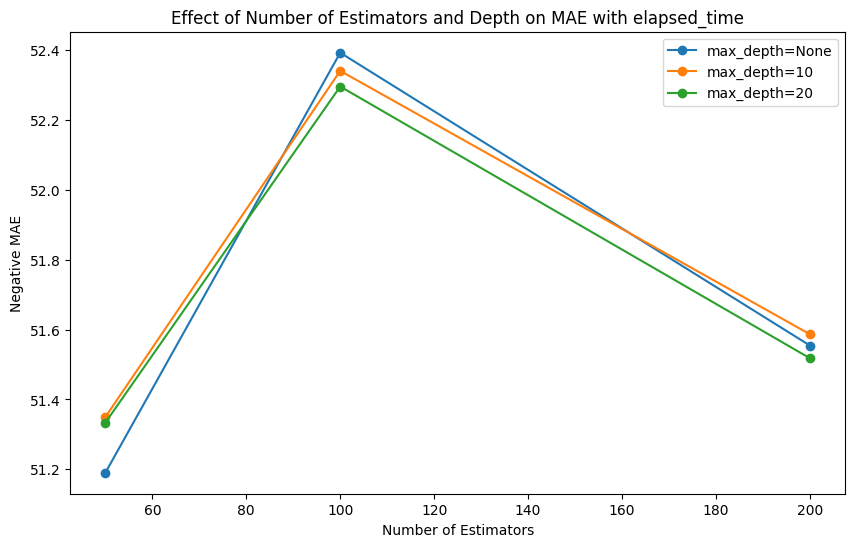

In [ ]:
# TASK 5.C

# calculate the elapsed time for each row in the dataset and handle missing vlaues
case_start_time = df.groupby(column_Sepsis_CaseID)['Complete Timestamp'].transform('min')
df['elapsed_time'] = (df['Complete Timestamp'] - case_start_time).dt.total_seconds()
df['elapsed_time'] = df['elapsed_time'].fillna(df['elapsed_time'].median())

# data preprocessing
scaler = MinMaxScaler()
df_scale = df.copy()
df_scale[['Age', 'Leucocytes', 'CRP', 'LacticAcid', 'elapsed_time']] = scaler.fit_transform(df_scale[['Age', 'Leucocytes', 'CRP', 'LacticAcid', 'elapsed_time']])

# apply the aggregation encoding for activities
df_scale_encoded = agg_per_event_encoding(df_scale, column_Sepsis_CaseID, column_Sepsis_Activity)

# train-test split
X_train, X_test, y_train, y_test = train_test_time_based_split(df_scale_encoded, time_threshold, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

# fill NaNs so we get no errors
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train a regression model (e.g., Random Forest Regressor)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate the regressor on the test data and print the errors
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Random Forest Regressor Performance:\nMAE: {mae_best:.4f}, MSE: {mse_best:.4f}, RMSE: {rmse_best:.4f}, R^2: {r2_best:.4f}")

# simply for checking the the elapsed time is calculated correclty
df_filtered = df[df['Case ID'].isin(['A'])]
print("\nElapsed Time Calculation:")
print(df_filtered[['Case ID', 'Complete Timestamp', 'elapsed_time']])

# Plotting results
results = grid_search.cv_results_
n_estimators = [50, 100, 200]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, -results['mean_test_score'][::6], marker='o', label='max_depth=None')
plt.plot(n_estimators, -results['mean_test_score'][1::6], marker='o', label='max_depth=10')
plt.plot(n_estimators, -results['mean_test_score'][2::6], marker='o', label='max_depth=20')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MAE')
plt.title('Effect of Number of Estimators and Depth on MAE with elapsed_time')
plt.legend()
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Random Forest Regressor Performance:
MAE: 18.2824, MSE: 1314.5753, RMSE: 36.2571, R^2: 0.0424


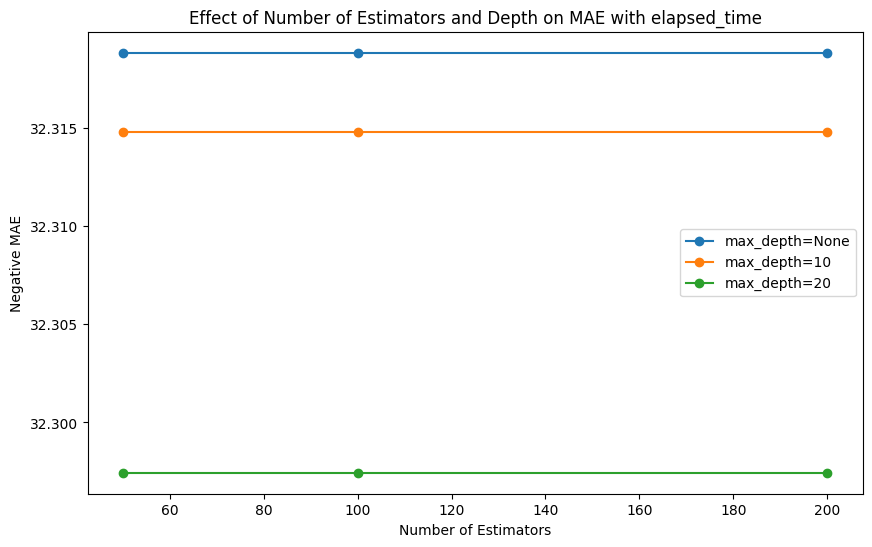

Number visualization showing that the MAE values are not all the exact same for all parameters (even though it may look like it in the visualization):
n_estimators: 50, max_depth: None, min_samples_split: 2, MAE: 32.3188
n_estimators: 100, max_depth: None, min_samples_split: 2, MAE: 32.3148
n_estimators: 200, max_depth: None, min_samples_split: 2, MAE: 32.2974
n_estimators: 50, max_depth: None, min_samples_split: 5, MAE: 32.3188
n_estimators: 100, max_depth: None, min_samples_split: 5, MAE: 32.3148
n_estimators: 200, max_depth: None, min_samples_split: 5, MAE: 32.2974
n_estimators: 50, max_depth: 10, min_samples_split: 2, MAE: 32.3188
n_estimators: 100, max_depth: 10, min_samples_split: 2, MAE: 32.3148
n_estimators: 200, max_depth: 10, min_samples_split: 2, MAE: 32.2974
n_estimators: 50, max_depth: 10, min_samples_split: 5, MAE: 32.3188
n_estimators: 100, max_depth: 10, min_samples_split: 5, MAE: 32.3148
n_estimators: 200, max_depth: 10, min_samples_split: 5, MAE: 32.2974
n_estimators:

In [ ]:
# TASK 5.D

def last_state_encoding(df, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column):
    # sort by CaseID and timestamp to ensure events are in the correct order
    df_sorted = df.sort_values(by=[column_Sepsis_CaseID, column_Sepsis_Timestamps])
    
    # for each case, get the last event (activity) from the sorted dataframe
    last_state_df = df_sorted.groupby(column_Sepsis_CaseID).tail(1)
    
    # retain the original Activity column
    last_state_encoded = last_state_df[[column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column]].copy()
    
    # apply one-hot encoding to the Activity column
    onehot = pd.get_dummies(last_state_encoded[column_Sepsis_Activity], prefix=column_Sepsis_Activity)
    last_state_encoded = pd.concat([last_state_encoded, onehot], axis=1)
    
    return last_state_encoded

# apply last-state encoding for activities
df_scale_encoded_last_state = last_state_encoding(df_scale, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

# aligning features correctly after encoding
X_last_state = df_scale_encoded_last_state.drop(columns=[column_Sepsis_CaseID])

# train-test split
X_train, X_test, y_train, y_test = train_test_time_based_split(df_scale_encoded_last_state, time_threshold, column_Sepsis_CaseID, column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

# fill NaNs so we get no errors
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train a regression model (e.g., Random Forest Regressor)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate the regressor on the test data and print the errors
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Random Forest Regressor Performance:\nMAE: {mae_best:.4f}, MSE: {mse_best:.4f}, RMSE: {rmse_best:.4f}, R^2: {r2_best:.4f}")

# Plotting results
results = grid_search.cv_results_
n_estimators = [50, 100, 200]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, -results['mean_test_score'][::6], marker='o', label='max_depth=None')
plt.plot(n_estimators, -results['mean_test_score'][1::6], marker='o', label='max_depth=10')
plt.plot(n_estimators, -results['mean_test_score'][2::6], marker='o', label='max_depth=20')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MAE')
plt.title('Effect of Number of Estimators and Depth on MAE with elapsed_time')
plt.legend()
plt.show()

# Print out the parameters and their corresponding mean test scores for the negative MAE
print("Number visualization showing that the MAE values are not all the exact same for all parameters (even though it may look like it in the visualization):")
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    mean_test_score = -grid_search.cv_results_['mean_test_score'][i]

    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, MAE: {mean_test_score:.4f}")


## Task 6.  Report your results and discuss your findings

By now, you have trained and applied a regressor and evaluated its performance on
(1) the non-bucketed training and test set with all possible prefix length.
(2) three buckets of different prefix length.
(3 & 4) and two other methods you tried (e.g., a different encoding or with additional features).

You have created tables or figures which you can add to your report.

Create an overview table or figure that compares the performance of each method on the data set, for example, see the table here below.


Discuss your findings and reflect on the following questions in your report:
- According to the error measures, which one would you suggest as the optimal method (preprocessing + encoding + algorithm)?
- Are there any discrepancies between the MAE, MSE, RMSE, and R^2 measures in terms of which model/method performs the best? If yes, how would you explain these discrepancies.
- Which one of the MAE, MSE, RMSE, and R^2 would you use for selecting the model? Why?
- Which one of the encoding would you suggest for this data set? Why?
- Which features have a big influence on predicting the remaining time?





| Encoding | Model | Training MAE  | Test MAE |  Training MSE  |  Test MSE  | Training R^2 | Test R^2 |... |
|------|------|------|------|------|------|------|------|-----|
|  Agg-state and no bucketing |  RF regressor |  |  | || | |
|  Agg-state and prefix length 5 |RF regressor       |  |  | || | |
|   Agg-state and prefix length 10 |RF regressor     |  |  | || | |
|   Agg-state and prefix length 15 |RF regressor     |  |  | || | |
|   last-state |RF regressor    |  |  | || | |
|   last-state + additional features |RF regressor    |  |  | || | |












## Bonus Tasks

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 0.5 extra point added to the total 14 points.

1. Train a MLP for regression. (If you have used MLP for Task 3, then train another regressor of interest. Evaluate the performance. Explain this in your report.)
2. Train an Autoencoder for feature reduction/learning and evaluate whether it helps improve the performance. Explain this in your report.

